In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


# ignore futurewarnings, settingswithcopywarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

In [34]:
# read in data ScanRecords.csv
df = pd.read_csv('ScanRecords.csv')
df.head(10)

,Date,Time,Duration,PatientType
0,2023-08-01,8.23,0.949176,Type 2
1,2023-08-01,8.49,0.479593,Type 1
2,2023-08-01,9.12,0.496112,Type 2
3,2023-08-01,10.26,0.691947,Type 2
4,2023-08-01,10.64,0.345412,Type 1
5,2023-08-01,11.07,0.422270,Type 1
6,2023-08-01,11.13,0.356129,Type 1
7,2023-08-01,11.33,0.688219,Type 2
8,2023-08-01,11.56,0.423303,Type 1
9,2023-08-01,11.89,0.690255,Type 2


In [35]:
# create df1 and df2 for the two different types of patients
df1 = df[df['PatientType'] == 'Type 1']
df2 = df[df['PatientType'] == 'Type 2']

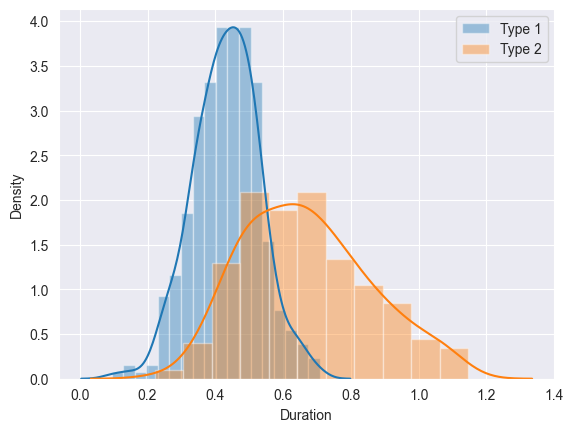

In [36]:
# plot the distribution of duration of the two types of patients
sns.distplot(df1['Duration'], label = 'Type 1')
sns.distplot(df2['Duration'], label = 'Type 2')
plt.legend()
plt.show()


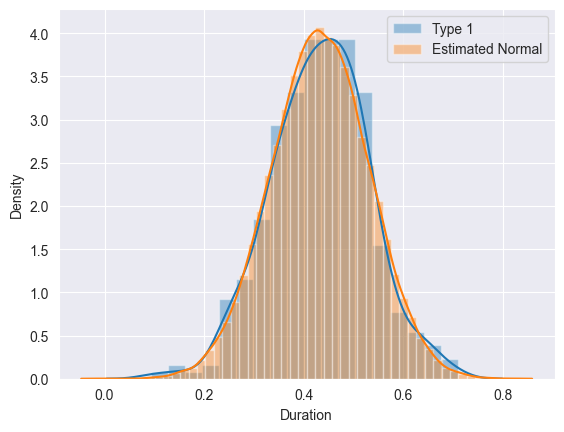

In [37]:
# get mean and std of df1
df1_mean = df1['Duration'].mean()
df1_std = df1['Duration'].std()

# plot df1 and a new normal distribution with df1_mean and df1_std
sns.distplot(df1['Duration'], label = 'Type 1')
sns.distplot(np.random.normal(df1_mean, df1_std, 100000), label = 'Estimated Normal')
plt.legend()
plt.show()


In [38]:
df1_mean, df1_std

(0.43266079748623376, 0.0977742425980323)

In [39]:
from sklearn.utils import resample

# Define a function to perform bootstrapping
def bootstrap_mean_std(data, n_bootstrap=1000):
    bootstrap_means = np.zeros(n_bootstrap)
    bootstrap_stds = np.zeros(n_bootstrap)

    # Perform bootstrapping
    for i in range(n_bootstrap):
        sample = resample(data)
        bootstrap_means[i] = sample.mean()
        bootstrap_stds[i] = sample.std()

    return bootstrap_means, bootstrap_stds

# Apply bootstrapping on the 'duration' column of the DataFrame
bootstrap_means, bootstrap_stds = bootstrap_mean_std(df1['Duration'])

# Calculate the 95% confidence intervals for the mean and standard deviation
confidence_interval_mean = np.percentile(bootstrap_means, [2.5, 97.5])
confidence_interval_std = np.percentile(bootstrap_stds, [2.5, 97.5])

bootstrap_means.mean(), bootstrap_stds.mean(), confidence_interval_mean, confidence_interval_std


(0.4327665250025459,
 0.09736469087209837,
 array([0.42301286, 0.44207969]),
 array([0.09020102, 0.10482955]))

# Mean and std
Non bootstrapped:
    mean = 0.43266079748623376
    std  = 0.0977742425980323
Bootstrapped:
    mean = 0.4327542613868652
    std  = 0.09758515315440086


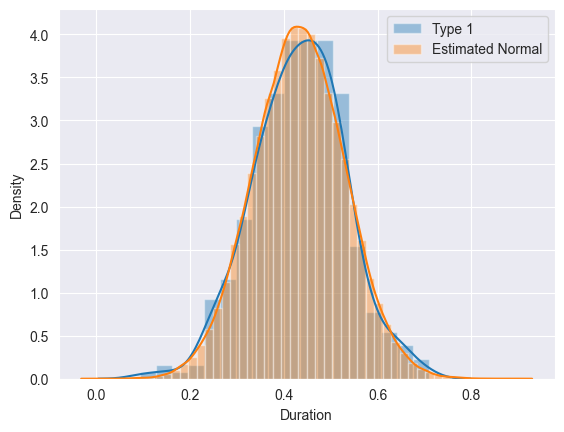

In [40]:
# plot df1 and a new normal distribution with df1_mean and df1_std
sns.distplot(df1['Duration'], label = 'Type 1')
sns.distplot(np.random.normal(bootstrap_means.mean(), bootstrap_stds.mean(), 100000), label = 'Estimated Normal')
plt.legend()
plt.show()

In [41]:
# create a new column for the difference of the time of a row and the previous row
# be wary of the dates, on new days the time difference will be negative
df1['TimeDiff'] = df1['Time'].diff()
df2['TimeDiff'] = df2['Time'].diff()


In [42]:
# set all negative values to 0
df1['TimeDiff'] = df1['TimeDiff'].apply(lambda x: 0 if x < 0 else x)
df2['TimeDiff'] = df2['TimeDiff'].apply(lambda x: 0 if x < 0 else x)

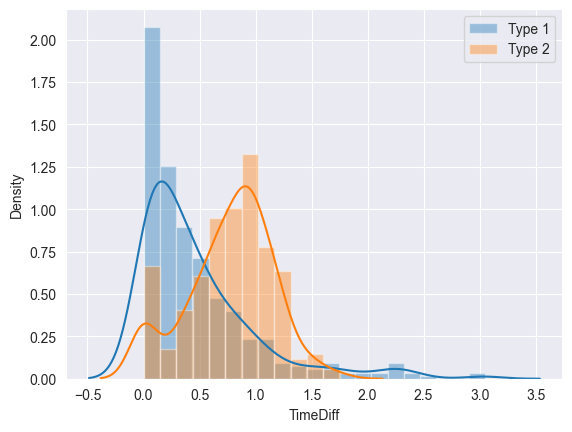

In [43]:
# plot the distribution of the time of the two types of patients
sns.distplot(df1['TimeDiff'], label = 'Type 1')
sns.distplot(df2['TimeDiff'], label = 'Type 2')
plt.legend()
plt.show()

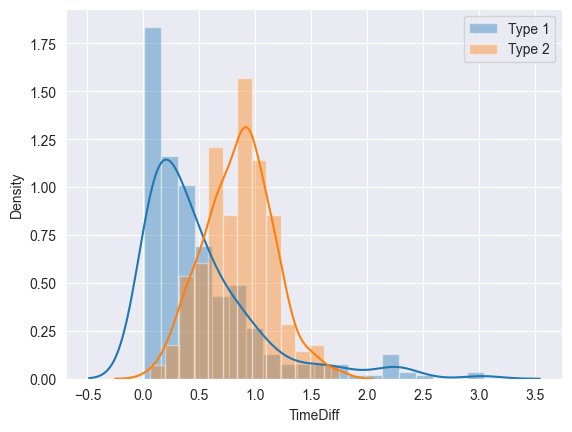

In [44]:
# same thing but dropping negative values
df1['TimeDiff'] = df1['Time'].diff()
df2['TimeDiff'] = df2['Time'].diff()

# drop negative rows
df1 = df1[df1['TimeDiff'] > 0]
df2 = df2[df2['TimeDiff'] > 0]


sns.distplot(df1['TimeDiff'][df1['TimeDiff'] > 0], label = 'Type 1')
sns.distplot(df2['TimeDiff'][df2['TimeDiff'] > 0], label = 'Type 2')
plt.legend()
plt.show()

In [45]:


# Estimate the parameter (lambda) of the Poisson distribution
# For a Poisson distribution, the mean is the estimator of lambda
estimated_lambda = df1['TimeDiff'].mean()

# Bootstrapping for Poisson distribution
def bootstrap_poisson_lambda(data, n_bootstrap=1000):
    bootstrap_lambdas = np.zeros(n_bootstrap)

    # Perform bootstrapping
    for i in range(n_bootstrap):
        sample = resample(data)
        bootstrap_lambdas[i] = sample.mean()

    return bootstrap_lambdas

# Apply bootstrapping on the 'TimeDiff' column of the DataFrame
bootstrap_lambdas = bootstrap_poisson_lambda(df1['TimeDiff'])

# Calculate the 95% confidence interval for lambda
confidence_interval_lambda = np.percentile(bootstrap_lambdas, [2.5, 97.5])

estimated_lambda, bootstrap_lambdas.mean(), confidence_interval_lambda


(0.5150142450142451, 0.5159475783475783, array([0.46352849, 0.572401  ]))

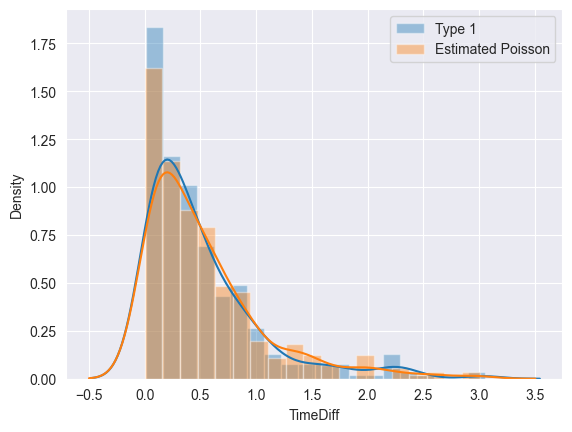

In [46]:
# plot df1 TimeDiff and a new poisson distribution with estimated_lambda
sns.distplot(df1['TimeDiff'], label = 'Type 1')
sns.distplot(np.random.exponential(estimated_lambda, 351), label = 'Estimated Poisson')
plt.legend()
plt.show()

In [47]:
df1.TimeDiff

4      2.15
5      0.43
6      0.06
8      0.43
10     0.44
       ... 
608    1.00
610    0.92
613    1.99
615    0.33
617    0.76
Name: TimeDiff, Length: 351, dtype: float64

In [48]:
import numpy as np
import pandas as pd
import scipy.stats as st
import warnings

# A list of candidate distributions to check
DISTRIBUTIONS = [
    st.norm, st.gamma, st.expon, st.cauchy, st.lognorm, st.beta, st.uniform
]

def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # Fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # If best fit so far, store the fit and parameters
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)



Best fit distribution for column is: gamma
Best fit parameters for column are: (14.767504836992813, -0.03816482525493267, 0.04792771454159874)


In [ ]:
# To use this function, you would pass your dataframe column to it like so:
data_column = df2['Duration']  # or df2['TimeDiff'] for the other column
best_fit_name, best_fit_params = best_fit_distribution(data_column)
print(f"Best fit distribution for column is: {best_fit_name}")
print(f"Best fit parameters for column are: {best_fit_params}")

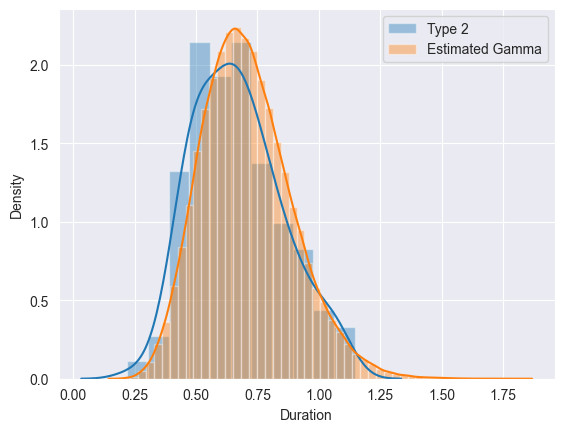

In [49]:
# plot df2 Duration and gamma distribution with best_fit_params
sns.distplot(df2['Duration'], label = 'Type 2')
sns.distplot(np.random.gamma(best_fit_params[0], best_fit_params[2], 100000), label = 'Estimated Gamma')
plt.legend()
plt.show()


In [50]:
data_column = df2['TimeDiff']  # or df2['TimeDiff'] for the other column
best_fit_name, best_fit_params = best_fit_distribution(data_column)
print(f"Best fit distribution for column is: {best_fit_name}")
print(f"Best fit parameters for column are: {best_fit_params}")

Best fit distribution for column is: norm
Best fit parameters for column are: (0.8515277777777778, 0.30425528262656815)


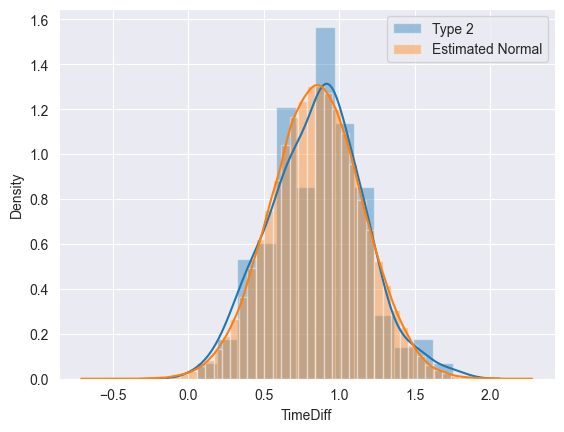

In [51]:
# plot df2 TimeDiff and normal distribution with best_fit_params
sns.distplot(df2['TimeDiff'], label = 'Type 2')
sns.distplot(np.random.normal(best_fit_params[0], best_fit_params[1], 100000), label = 'Estimated Normal')
plt.legend()
plt.show()
